In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [15]:
def update(board):
    """Update the board based on Conway's Game of Life rules."""
    new_board = board.copy()
    rows, cols = board.shape

    for x in range(rows):
        for y in range(cols):
            # Count the 8 neighbors
            neighbors = (
                np.sum(
                    board[
                        max(x - 1, 0) : min(x + 2, rows),
                        max(y - 1, 0) : min(y + 2, cols),
                    ]
                )
                - board[x, y]
            )

            # Apply the rules of Conway's Game of Life
            if board[x, y] and not 2 <= neighbors <= 3:
                new_board[x, y] = 0
            elif not board[x, y] and neighbors == 3:
                new_board[x, y] = 1

    return new_board

In [16]:
generated_file = open("generated.txt", "r")
simulated_file = open("simulated.txt", "r")
predicted_file = open("predicted.txt", "r")

# Load the boards from the files. Each row is one line of the file. Boards are separated by newlines.
generated_boards = [
    np.array([[int(c) for c in line] for line in board.split("\n")])
    for board in generated_file.read().split("\n\n")[:-1]
]
simulated_boards = [
    update(np.array([[int(c) for c in line] for line in board.split("\n")]))
    for board in simulated_file.read().split("\n\n")[:-1]
]
predicted_boards = [
    np.array([[int(c) for c in line] for line in board.split("\n")])
    for board in predicted_file.read().split("\n\n")[:-1]
]

In [26]:
 # Compute the accuracy of the model against the simulation
n_different = 0
n_total = 0
difference_board = np.zeros(generated_boards[0].shape)

correct_count = np.zeros(2**9)
predicted_alive = np.zeros(2**9)
predicted_dead = np.zeros(2**9)
totals = np.zeros(2**9)

simulated_transitions = np.zeros((2,2))
predicted_transitions = np.zeros((2,2))
correct_transitions = np.zeros((2,2))
transitions_count = np.zeros((2,2))

for generated_board, simulated_board, predicted_board in zip(
    generated_boards, simulated_boards, predicted_boards
):
    difference_board += np.abs(simulated_board - predicted_board)

    n_different += np.sum(np.abs(simulated_board - predicted_board))
    n_total += np.prod(simulated_board.shape)

    for i in range(1, generated_board.shape[0] - 1):
        for j in range(1, generated_board.shape[1] - 1):
            subgrid = generated_board[i - 1 : i + 2, j - 1 : j + 2]
            # Convert the subgrid to its integer index from its binary representation
            subgrid_index = int("".join(str(c) for c in subgrid.flatten()), 2)

            transitions_count[generated_board[i, j], simulated_board[i, j]] += 1

            if predicted_board[i, j] == simulated_board[i, j]:
                correct_count[subgrid_index] += 1
                correct_transitions[generated_board[i, j], predicted_board[i, j]] += 1

            if predicted_board[i, j] == 1:
                predicted_alive[subgrid_index] += 1
            else:
                predicted_dead[subgrid_index] += 1

            totals[subgrid_index] += 1

            simulated_transitions[generated_board[i, j], simulated_board[i, j]] += 1
            predicted_transitions[generated_board[i, j], predicted_board[i, j]] += 1

print(f"Accuracy: {1 - n_different / n_total}")
print(f"Simulated transitions:\n{simulated_transitions/np.sum(simulated_transitions)}")
print(f"Predicted transitions:\n{predicted_transitions/np.sum(predicted_transitions)}")
print(f"Correct transitions:\n{correct_transitions/transitions_count}")

Accuracy: 0.6145467032967034
Simulated transitions:
[[0.39116157 0.10928915]
 [0.33108688 0.1684624 ]]
Predicted transitions:
[[0.42721927 0.07323146]
 [0.31286487 0.18668441]]
Correct transitions:
[[0.8430727  0.10840534]
 [0.63224426 0.38539941]]


In [25]:
np.sum(transitions_count)

46592.0

In [18]:
# Compute the confusion matrix
confusion_matrix = np.zeros((2, 2))

for generated_board, simulated_board, predicted_board in zip(
    generated_boards, simulated_boards, predicted_boards
):
    for i in range(1, generated_board.shape[0] - 1):
        for j in range(1, generated_board.shape[1] - 1):
            confusion_matrix[predicted_board[i, j], simulated_board[i, j]] += 1

# Compute percentages
confusion_matrix /= np.sum(confusion_matrix, axis=1, keepdims=True)

print("Confusion matrix:")
print(confusion_matrix)

Confusion matrix:
[[0.72843803 0.27156197]
 [0.70462428 0.29537572]]


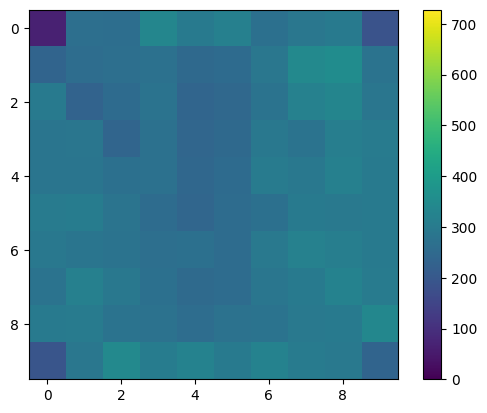

In [19]:
# Plot the difference board, with the legend indicating the number of boards that were different at each cell
plt.imshow(difference_board, norm=plt.Normalize(0, len(generated_boards)))
plt.colorbar()
plt.show()

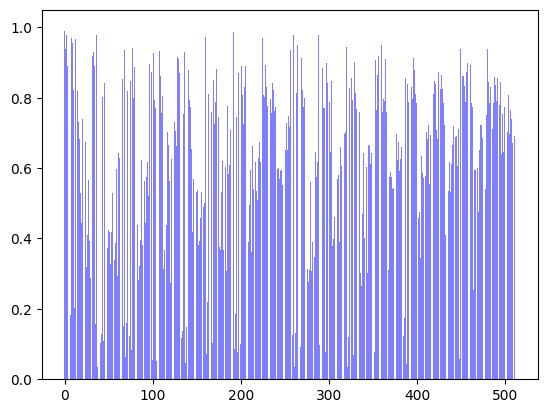

In [20]:
# Plot a bar chart of the percentage of correct predictions per subgrid
plt.bar(
    range(2**9),
    correct_count / totals,
    color="blue",
    label="Correct",
    alpha=0.5,
)
plt.show()

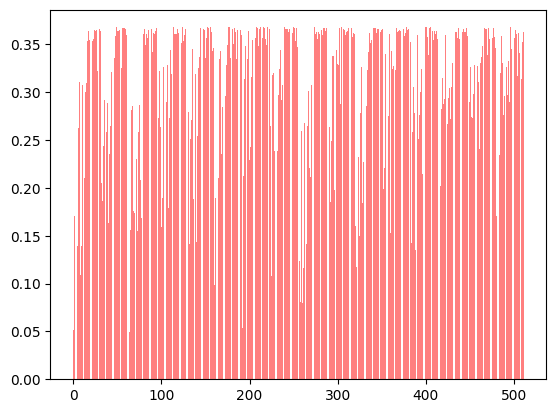

Weighted entropy: 0.31139033589205495


In [28]:
# Compute the weighted entropy of the alive / dead predictions
entropy = np.zeros(2**9)
p_alive = np.zeros(2**9)
p_dead = np.zeros(2**9)
for i in range(2**9):
    if totals[i] == 0:
        continue
    p_alive[i] = predicted_alive[i] / totals[i]
    p_dead[i] = predicted_dead[i] / totals[i]

    # Compute the entropy, catching NaNs
    entropy[i] = (
        -p_alive[i] * np.log(p_alive[i])
        if p_alive[i] > 0
        else 0 - p_dead[i] * np.log(p_dead[i])
        if p_dead[i] > 0
        else 0
    )

# Plot a bar chart of the entropy per subgrid
plt.bar(range(2**9), entropy, color="red", label="Entropy", alpha=0.5)
plt.show()

# Compute the weighted entropy of the alive / dead predictions
weights = totals / np.sum(totals)
weighted_entropy = np.sum(weights * entropy)
print(f"Weighted entropy: {weighted_entropy}")

In [29]:
states_predictions_file = open("predicted_next_states.txt", "r")
states_computed_file = open("simulated_next_states.txt", "r")

consistency = 0
for i in range(2**9):
    predicted = int(states_predictions_file.readline())
    if predicted == 0:
        consistency += p_dead[i]
    else:
        consistency += p_alive[i]

print(f"Consistency: {consistency / 2**9}")


Consistency: 0.46583223789777933
